# Семинар: логистическая регрессия и SVM

In [1]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

%matplotlib inline

## Линейная классификация

### Постановка задачи классификации

Пусть задана обучающая выборка $X = \left\{ \left( x_i, y_i \right) \right\}_{i=1}^l, x_i \in \mathbb{X}, y_i \in \mathbb{Y},$ — $l$ пар объект-ответ, где
$\mathbb{X}$ — пространство объектов,
$\mathbb{Y}$ — пространство ответов.


### Логистическая регрессия

Рассмотрим в качестве верхней оценки пороговой функции потерь логистическую функцию:

$$\tilde{L}(M) = \log (1 + \exp(-M)).$$

Таким образом, необходимо решить следующую оптимизационную задачу:
$$\frac{1}{l} \sum_{i=1}^l \tilde{L} (M_i) = \frac{1}{l} \sum_{i=1}^l \log (1 + \exp (-y_i \langle w, x_i \rangle)) \to \min_w$$

Получившийся метод обучения называется **логистической регрессией**.

Одно из полезных свойств логистической регрессии, которое будет изучено нами несколько позднее, — тот факт, что она позволяет предсказывать помимо метки класса ещё и вероятность принадлежности каждому из них, что может быть полезным в некоторых задачах.

**Пример**: Вы работаете в банке и хотите выдавать кредиты только тем клиентам, которые вернут его с вероятностью не меньше 0.9.

Попробуем сконструировать функцию потерь из других соображений.
Если алгоритм $b(x) \in [0, 1]$ действительно выдает вероятности, то
они должны согласовываться с выборкой.
С точки зрения алгоритма вероятность того, что в выборке встретится объект $x_i$ с классом $y_i$,
равна $b(x_i)^{[y_i = +1]} (1 - b(x_i))^{[y_i = -1]}$.

Исходя из этого, можно записать правдоподобие выборки (т.е. вероятность получить такую выборку
с точки зрения алгоритма):
$$
    Q(a, X)
    =
    \prod_{i = 1}^{\ell}
        b(x_i)^{[y_i = +1]} (1 - b(x_i))^{[y_i = -1]}.
$$
Данное правдоподобие можно использовать как функционал для обучения алгоритма --
с той лишь оговоркой, что удобнее оптимизировать его логарифм:
$$
    -\sum_{i = 1}^{\ell} \left(
        [y_i = +1] \log b(x_i)
        +
        [y_i = -1] \log (1 - b(x_i))
    \right)
    \to
    \min
$$
Данная функция потерь называется логарифмической (log-loss).

Мы хотим предсказывать вероятности, то есть, чтобы наш алгоритм предсказывал числа в интервале [0, 1]. Этого легко достичь, если положить $b(x) = \sigma(\langle w, x \rangle)$,
где в качестве $\sigma$ может выступать любая монотонно неубывающая функция
с областью значений $[0, 1]$.
Мы будем использовать сигмоидную функцию: $\sigma(z) = \frac{1}{1 + \exp(-z)}$.
Таким образом, чем больше скалярное произведение $\langle w, x \rangle$,
тем больше будет предсказанная вероятность.

Подставим трансформированный ответ линейной модели в логарифмическую функцию потерь:
\begin{align*}
    -\sum_{i = 1}^{\ell} &\left(
        [y_i = +1]
        \log \frac{1}{1 + \exp(-\langle w, x_i \rangle)}
        +
        [y_i = -1]
        \log \frac{\exp(-\langle w, x_i \rangle)}{1 + \exp(-\langle w, x_i \rangle)}
    \right)
    =\\
    &=
    -\sum_{i = 1}^{\ell} \left(
        [y_i = +1]
        \log \frac{1}{1 + \exp(-\langle w, x_i \rangle)}
        +
        [y_i = -1]
        \log \frac{1}{1 + \exp(\langle w, x_i \rangle)}
    \right)
    =\\
    &=
    \sum_{i = 1}^{\ell} \left(
        [y_i = +1]
        \log (1 + \exp(-\langle w, x_i \rangle))
        +
        [y_i = -1]
        \log (1 + \exp(\langle w, x_i \rangle))
    \right)
    =\\
    &=
    \sum_{i = 1}^{\ell}
        \log \left(
            1 + \exp(-y_i \langle w, x_i \rangle)
        \right).
\end{align*}

Полученная функция в точности представляет собой логистические потери,
упомянутые в начале.
Линейная модель классификации, настроенная путём минимизации данного функционала,
называется логистической регрессией.
Как видно из приведенных рассуждений, она оптимизирует
правдоподобие выборки и дает корректные оценки вероятности принадлежности к положительному классу.


### Пример обучения логистической регрессии
#### Определение спама по тексту электронного письма

Попробуем при помощи моделей линейной классификации построить алгоритм, отделяющий спам от нормальной почты. Для экспериментов воспользуемся небольшим набором данных с [UCI](https://archive.ics.uci.edu/ml/datasets.html). Объекты в датасете соответствуют письмам, которые описаны признаками на основе текста письма, спам — положительный пример для классификации, хорошее письмо — отрицательный пример.


In [2]:
import pandas
from urllib.request import urlopen

SPAMBASE_NAMES_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names'
SPAMBASE_DATA_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data'

feature_names = [
    line.strip().split(b':')[0].decode("utf-8")
    for line in urlopen(SPAMBASE_NAMES_URL).readlines()[33:]
]
spam_data = pandas.read_csv(SPAMBASE_DATA_URL, header=None, names=(feature_names + ['spam']))
 
# X, y = spam_data.ix[:, :-1].values, spam_data.ix[:, -1].values
X, y = spam_data.iloc[:, :-1].values, spam_data.iloc[:, -1].values
 
spam_data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


### Обучение логистической регрессии

Разделим выборку на обучающую и тестовую в отношении 80/20 и обучим логистическую регрессию при помощи объекта [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [9]:
from sklearn.linear_model import LogisticRegression

# splitting data
train_part = 0.8
n_train = int(train_part * X.shape[0])
X_tr = X[:n_train]
X_test = X[n_train:]

X_tr = scaler.fit_transform(X_tr)
X_test = scaler.transform(X_test)

y_tr = y[:n_train]
y_test = y[n_train:]

# training
lr = LogisticRegression(solver='lbfgs',  max_iter=100)
lr = lr.fit(X_tr, y_tr)

Оценим долю верных прогнозов полученной модели (accuracy) при помощи соответствующей функции из модуля [sklearn.metrics](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

In [10]:
from sklearn import metrics

preds = lr.predict(X_test)

print (f'Accuracy = {metrics.accuracy_score(y_test, preds)}')

Accuracy = 0.8208469055374593


Сгенерируем двумерную искуственную выборку из 2 различных нормальных распределений:

/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  import sys


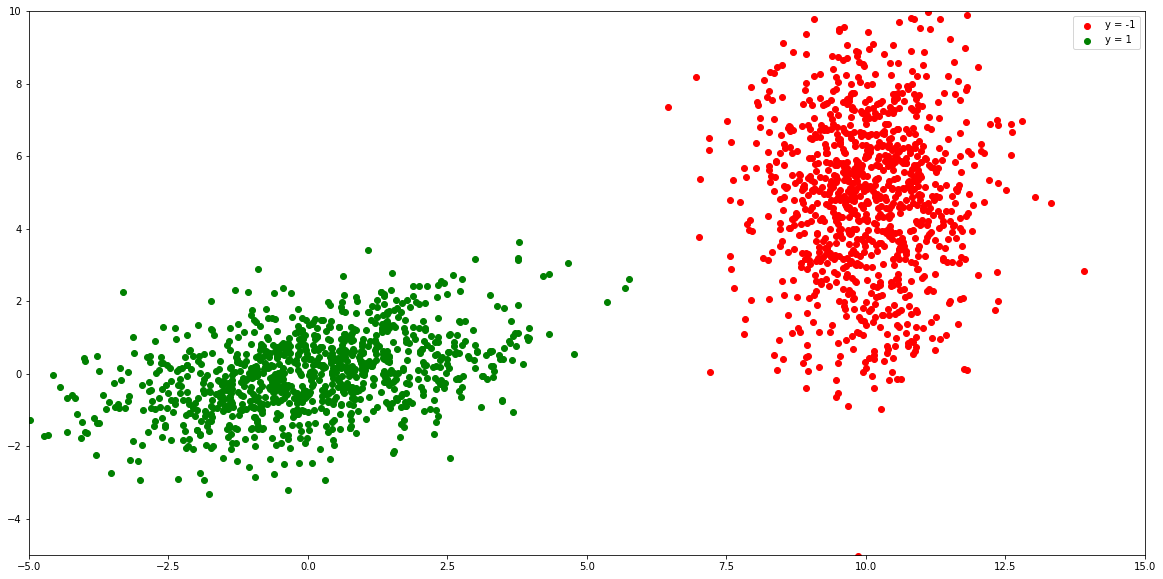

In [11]:
plt.figure(figsize=(20,10))
mean0 = [10, 5]
cov0 = [[1, 0], [0, 5]]  # diagonal covariance
data0 = np.random.multivariate_normal(mean0, cov0, 1000)
mean1 = [0, 0]
cov1 = [[3, 1], [0, 1]]
data1 = np.random.multivariate_normal(mean1, cov1, 1000)
data = np.vstack((data0, data1))
y_vis = np.hstack((-np.ones(1000), np.ones(1000)))


plt.scatter(data0[:, 0], data0[:, 1], c='red')
plt.scatter(data1[:, 0], data1[:, 1], c='green')
plt.legend(['y = -1', 'y = 1'])
axes = plt.gca()
axes.set_xlim([-5,15])
axes.set_ylim([-5,10])
plt.show()

Обучим логистическую регрессию:

In [14]:
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(data, y_vis, test_size=0.2)

from sklearn import linear_model

logreg = linear_model.LogisticRegression(penalty = 'l2')
logreg.fit(X_train_vis, y_train_vis)

/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Полученные в результате оптимизации коэффициенты линейной модели содержатся в атрибутах coef\_ и intercept\_ соответствующего объекта. Визуализируем разделяющую гиперплоскость алгоритма и рассмотрим значения предсказанных моделью вероятностей принадлежности нового объекта каждому из классов в зависимости от его координат.

In [15]:
print(logreg.coef_, logreg.intercept_)

[[-1.10159573 -0.28952114]] [6.36453144]


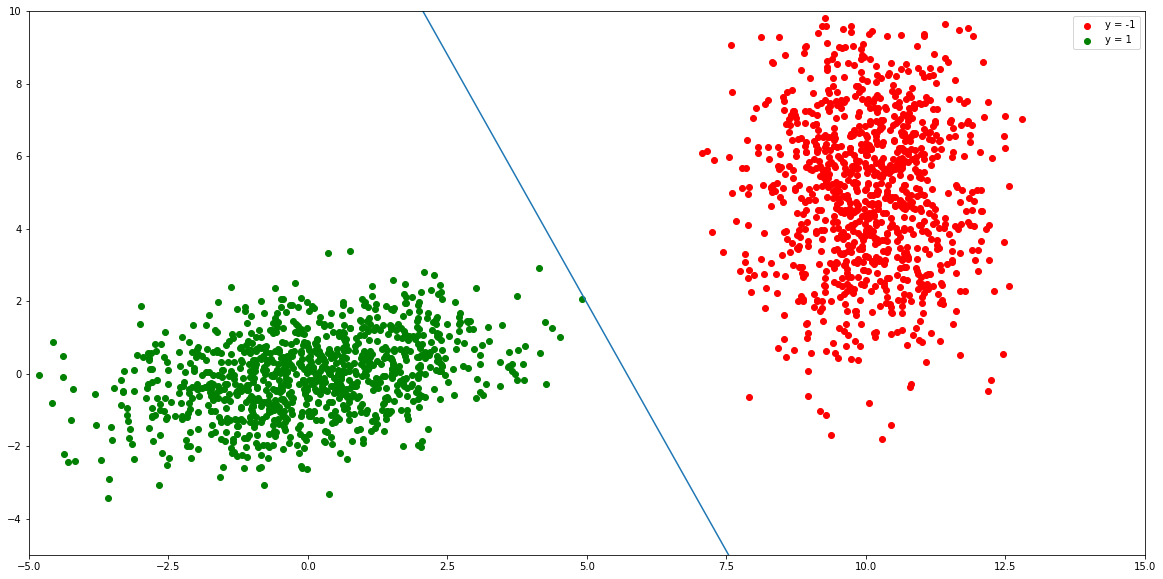

In [16]:
w_1 = logreg.coef_[0][0]
w_2 = logreg.coef_[0][1]
w_0 = logreg.intercept_[0]


plt.figure(figsize=(20,10))
plt.scatter(data0[:, 0], data0[:, 1], c='red')
plt.scatter(data1[:, 0], data1[:, 1], c='green')
plt.legend(['y = -1', 'y = 1'])
x_arr = np.linspace(-10, 15, 3000)
plt.plot(x_arr, -(w_0 + w_1 * x_arr) / w_2)
axes = plt.gca()
axes.set_xlim([-5,15])
axes.set_ylim([-5,10])
plt.show()

P(y = -1|x) = 0.9955795453646831
P(y = 1|x) = 0.004420454635316965


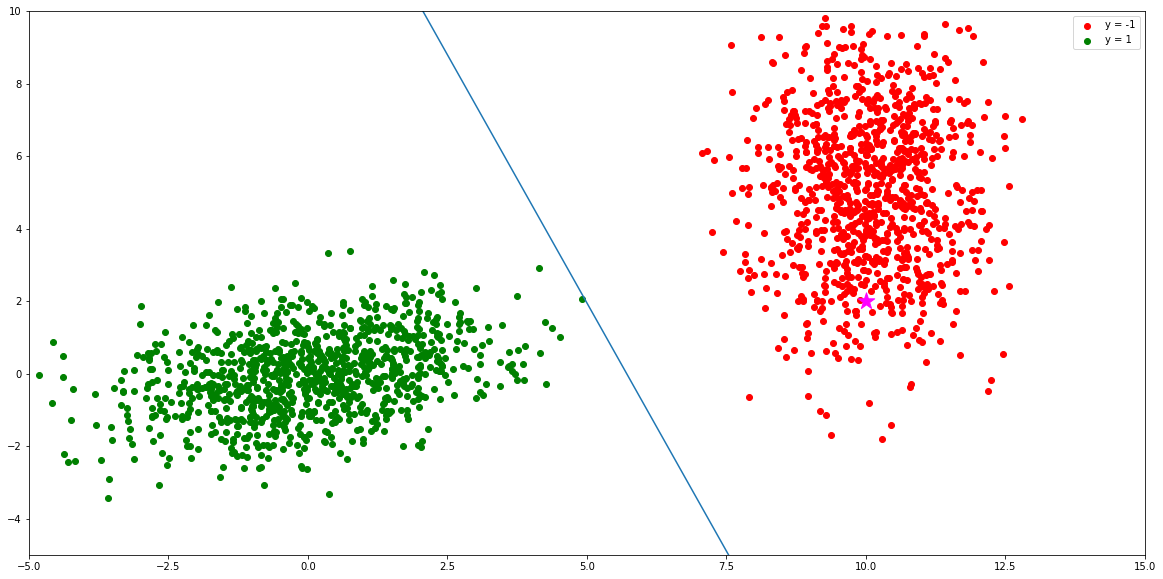

In [14]:
point = np.array([[10, 2]]) # изменяем только координаты объекта

plt.figure(figsize=(20,10))
plt.scatter(data0[:, 0], data0[:, 1], c='red')
plt.scatter(data1[:, 0], data1[:, 1], c='green')
plt.scatter(point[:, 0], point[:, 1], marker = '*', s = 300, color = 'magenta')
plt.legend(['y = -1', 'y = 1'])
x_arr = np.linspace(-10, 15, 3000)
plt.plot(x_arr, -(w_0 + w_1 * x_arr) / w_2)
axes = plt.gca()
axes.set_xlim([-5,15])
axes.set_ylim([-5,10])
prob = logreg.predict_proba(point)
print (f'P(y = -1|x) = {prob[0][0]}')
print (f'P(y = 1|x) = {prob[0][1]}')
plt.show()

### SGDClassifier

Объект [SGDClissifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) позволяет обучать линейные модели классификации и регрессии с помощью стохастического градиентного спуска.

Полезные параметры:
* loss - функция потерь (по факту то, какую модель обучаем): **hinge** (SVM), **log** (логистическая регрессия), **perceptron** (персептрон) и другие;
* penalty - тип регуляризации: **l1**, **l2**, **elasticnet** (смесь l1 и l2 регуляризации);
* alpha - коэффициент регуляризации;
* fit_intercept - необходимо ли добавлять в модель свободный член (True/False);
* n_iter - число эпох (полных проходов по выборке) при обучении;
* learning_rate - шаг градиентного спуска (оптимизируется по умолчанию).

In [18]:
from sklearn.linear_model import SGDClassifier
lr_sgd = SGDClassifier(loss="log", alpha=0.05, n_iter=200, fit_intercept=True)
lr_sgd.fit(X_tr, y_tr)
preds_sgd = lr_sgd.predict(X_test)
print 'Accuracy =', metrics.accuracy_score(y_test, preds_sgd)

Accuracy = 0.86319218241


## Оценка качества работы классификатора
### Бинарные метрики
Напомним метрики, изученные нами на прошлом семинаре

Часто рассматриваются следующие метрики качества бинарной классификации:
  - Доля правильных ответов (Accuracy):
  $$accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$
  - Точность/precision (доля действительно положительных объектов среди объектов, выделенных алгоритмом):
  $$precision = \frac{TP}{TP + FP}$$
  - Полнота/recall (доля выделенных алгоритмом объектов среди всех положительных объектов выборки):
  $$recall = \frac{TP}{TP + FN}$$
  - $F_1$-мера (среднее гармоническое между точностью и полнотой)
  $$F_1 = \frac{2 \cdot Precision \cdot Recall}{Precision + Recall}$$



Также распространены ROC-кривые и Precision/Recall кривые.
 - По осям Ox и Oy ROC-кривой отложены соответственно False Positive Rate (FPR) и True Positive Rate (TPR):
 $$FPR = \frac{FP}{FP + TN},$$
 $$TPR = \frac{TP}{FN + TP}.$$
 - По осям Ox и Oy PR-кривой отложены соответственно Recall и Precision.


В случае, если необходимо сравнить качество классификаторов вне зависимости от порога, применяют интегральные числовые метрики, например AUC-ROC (**A**rea **U**nder RO**C**) — площадь под ROC-кривой классификатора. AUC-ROC идеально работающего классификатора равно 1. Идеальный случайный классификатор в среднем имеет AUC-ROC=0.5.

Построим описанные кривые для логистической регрессии, обученной на описанном выше датасете.

* PR-кривая проходит через точку (0,0).

* Если при каком-то значении порога $t$ алгоритм $a(x)$ идеально разделяет объекты 2 классов, то PR-кривая проходит через точку (1,1).


In [42]:
%matplotlib inline
from sklearn.model_selection import train_test_split


X_train_curve, X_test_curve, y_train_curve, y_test_curve = train_test_split(X, y, test_size=0.2, random_state=20)

lr = LogisticRegression()
lr = lr.fit(X_train_curve, y_train_curve)

/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [43]:
from sklearn.metrics import precision_recall_curve

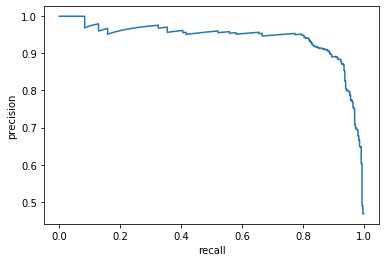

In [44]:
precision, recall, thresholds = precision_recall_curve(y_test_curve, lr.predict_proba(X_test_curve)[:, 1])
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [45]:
from sklearn.metrics import auc

auc(recall, precision)

0.9407285339520859

* ROC проходит через точки (0,0) и (1,1)
* Если при каком-то значении порога $t$ алгоритм $a(x)$ идеально разделяет объекты 2 классов, то ROC проходит через точку (0,1).


In [46]:
from sklearn.metrics import roc_curve

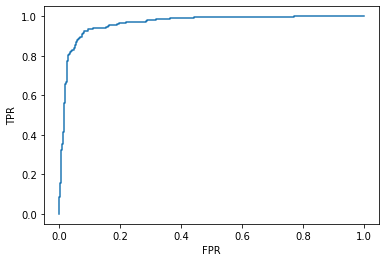

In [52]:
fpr, tpr, thresholds = roc_curve(y_test_curve, lr.predict_proba(X_test_curve)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [53]:
auc(fpr, tpr)

0.9643143937168263

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_curve, lr.predict(X_test_curve)[:])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [ ]:
auc(fpr, tpr)

## Валидация
Чтобы оценить качество работы алгоритма, необходимо провести валидацию. Это один из самых важных шагов в процессе решения задачи. Оценим accuracy для модели логистической регрессии в задаче про спам-письма на тестовой выборке. 

In [56]:
spam_data = pandas.read_csv(SPAMBASE_DATA_URL, header=None, names=(feature_names + ['spam']))
 
X, y = spam_data.iloc[:, :-1].values, spam_data.iloc[:, -1].values

# обучающая выборка
X_tr = X[:n_train]
y_tr = y[:n_train]

# валидационная выборка
X_test = X[n_train:]
y_test = y[n_train:]

# обучим ещё раз логистическую регрессию
lr = LogisticRegression()
lr = lr.fit(X_tr, y_tr)

#посмотрим на точность классификации

preds = lr.predict(X_test)
print (f'Accuracy = {metrics.accuracy_score(y_test, preds)}')

Accuracy = 0.8143322475570033


/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


А теперь попробуем перемешать объекты и повторим действия:

In [59]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=train_part, random_state=123)

# обучим ещё раз логистическую регрессию
lr = LogisticRegression()
lr = lr.fit(X_tr, y_tr)

#посмотрим на точность классификации

preds = lr.predict(X_test)
print (f'Accuracy = {metrics.accuracy_score(y_test, preds)}')

Accuracy = 0.9144254278728606


/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Как мы видим, качество классификации новых данных резко возросло. С чем это может быть связано? Рассмотрим вектор целевой переменной:

Text(0, 0.5, 'Target')

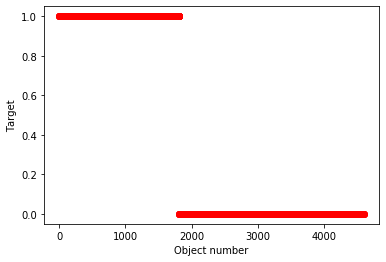

In [60]:
plt.plot(y, 'ro')
plt.xlabel('Object number')
plt.ylabel('Target')

Проблема заключалась в том, что в выборке примеры были упорядочены: сначала шли примеры положительного класса, а потом отрицательного. Поэтому нельзя забывать **перемешивать классы**.

Чтобы повысить устойчивость оценки качества, можно проводить разбиение выборки на обучающую и тестовую не один, $N$ раз, после чего усреднять результаты, полученные на $N$ контрольных выборках. Для этого можно использовать функцию [`sklearn.cross_validation.ShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html)

In [62]:
from sklearn.model_selection import ShuffleSplit

In [70]:
rs = ShuffleSplit(n_splits=5, test_size=.1, random_state=123)
rs.get_n_splits(X)

5

In [71]:
quals = []
lr = LogisticRegression()

for tr_ind, test_ind in rs.split(X):
    # using new set split for training and evaluating
    lr.fit(X[tr_ind, :], y[tr_ind])
    quals.append(metrics.roc_auc_score(y[test_ind], lr.predict_proba(X[test_ind,:])[:,1]))

/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Defau

In [74]:
print (f'Mean AUC-ROC = {np.mean(quals)}')
print (f'AUC-ROC standart deviation = {np.std(quals)}')

Mean AUC-ROC = 0.9726756650429662
AUC-ROC standart deviation = 0.007366049713338503


Рассмотрим зависимость оценки качества от пропорции, в которой выборка разбивается на обучающую и тестовую:

In [78]:
means = []
stds = []
xs = []
quals = []
for tr_size in np.arange(0.5,0.9,0.01):
    # set train size
    rs = ShuffleSplit(n_splits=5, train_size=tr_size, random_state=123)
    rs.get_n_splits(X)
    fold_quals = []
    lr = LogisticRegression(solver='liblinear')
    for tr_ind, test_ind in rs.split(X):
        # evaluate quality for each split
        lr.fit(X[tr_ind, :], y[tr_ind])
        qual = metrics.roc_auc_score(y[test_ind], lr.predict_proba(X[test_ind,:])[:,1])
        fold_quals.append(qual)
        quals.append(qual)
        xs.append(tr_size)
    # evaluation for current train set size
    means.append(np.mean(fold_quals))
    stds.append(np.std(fold_quals))

/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to c

Text(0, 0.5, 'AUC-ROC')

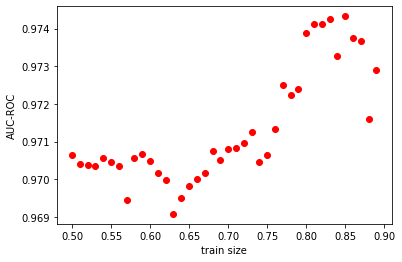

In [84]:
plt.plot(np.arange(0.5,0.9,0.01), means, 'ro')
plt.xlabel('train size')
plt.ylabel('AUC-ROC')

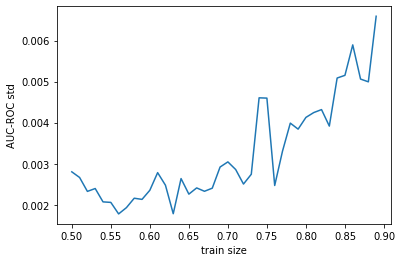

In [86]:
plt.plot(np.arange(0.5,0.9,0.01), stds)
plt.xlabel('train size')
plt.ylabel('AUC-ROC std');

### Несбалансированные классы

Если объём выборки невелик, а объектов одного класса значительно меньше, чем другого, то может сложиться ситуация, когда при случайном разбиении объектов меньшего класса не окажется в тестовой выборке, в связи с чем результаты оценки качества будут неустойчивы.

**Пример**: задача кредитного скоринга. Поскольку случаи невозврата кредита довольно редки, количество объектов отрицательного класса будет значительно меньше, чем положительного.

In [109]:
df = pd.read_csv('givemesomecredit')
X = df.drop('SeriousDlqin2yrs', axis=1)
X = X.fillna(X.mean()).as_matrix()
y = df['SeriousDlqin2yrs']
print (f'Доля заемщиков, не вернувших кредит: {y.mean()}')

Доля заемщиков, не вернувших кредит: 0.007126060001425212


/Users/danyache/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


- Всего 0.7% выборки составляют объекты положительного класса

- В таком случае необходимо производить стратификацию, то есть разбивать отдельно объекты каждого класса на обучение и тест (сохраняя их доли).

### Настройка параметров модели

Настройка наилучших параметров модели производится с использованием техник кросс-валидации (для оценки качества) и соответственно перебора параметров. 

Для перебора параметров можно использовать: 
  - Класс [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) — полный перебор параметров модели по сетке
  - Класс [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) — перебирает случайные комбинации параметров

# SVM

Рассмотрим теперь другой подход к построению функции потерь,
основанный на максимизации зазора между классами.
Будем рассматривать линейные классификаторы вида
$$
    a(x) = sign (\langle w, x \rangle + b), \qquad w \in R^d, b \in R.
$$

### Разделимый случай
Будем считать, что существуют такие параметры $w_*$ и $b_*$,
что соответствующий им классификатор $a(x)$ не допускает ни одной ошибки
на обучающей выборке.
В этом случае говорят, что выборка __линейно разделима__.

Пусть задан некоторый классификатор $a(x) = sign (\langle w, x \rangle + b)$.
Заметим, что если одновременно умножить параметры $w$ и $b$
на одну и ту же положительную константу,
то классификатор не изменится.
Распорядимся этой свободой выбора и отнормируем параметры так, что

\begin{equation}
\label{eq:svmNormCond}
    \min_{x \in X} | \langle w, x \rangle + b| = 1.
\end{equation}

Можно показать, что расстояние от произвольной точки $x_0 \in R^d$ до гиперплоскости,
определяемой данным классификатором, равно

$$
    \rho(x_0, a)
    =
    \frac{
        |\langle w, x \rangle + b|
    }{
        \|w\|
    }.
$$

Тогда расстояние от гиперплоскости до ближайшего объекта обучающей выборки равно

$$
    \min_{x \in X}
    \frac{
        |\langle w, x \rangle + b|
    }{
        \|w\|
    }
    =
    \frac{1}{\|w\|} \min_{x \in X} |\langle w, x \rangle + b|
    =
    \frac{1}{\|w\|}.
$$

Данная величина также называется __отступом (margin)__.

Таким образом, если классификатор без ошибок разделяет обучающую выборку,
то ширина его разделяющей полосы равна $\frac{2}{\|w\|}$.
Известно, что максимизация ширины разделяющей полосы приводит
к повышению обобщающей способности классификатора.
Вспомним также, что на повышение обобщающей способности направлена и регуляризация,
которая штрафует большую норму весов -- а чем больше норма весов,
тем меньше ширина разделяющей полосы.

Итак, требуется построить классификатор, идеально разделяющий обучающую выборку,
и при этом имеющий максимальный отступ.
Запишем соответствующую оптимизационную задачу,
которая и будет определять метод опорных векторов для линейно разделимой выборки (hard margin support vector machine):
\begin{equation}
\label{eq:svmSep}
    \left\{
        \begin{aligned}
            & \frac{1}{2} \|w\|^2 \to \min_{w, b} \\
            & y_i \left(
                \langle w, x_i \rangle + b
            \right) \geq 1, \quad i = 1, \dots, \ell.
        \end{aligned}
    \right.
\end{equation}


### Неразделимый случай
Рассмотрим теперь общий случай, когда выборку
невозможно идеально разделить гиперплоскостью.
Это означает, что какие бы $w$ и $b$ мы не взяли,
хотя бы одно из ограничений в предылущей задаче будет нарушено:

$$
    \exists x_i \in X:\
    y_i \left(
        \langle w, x_i \rangle + b
    \right) < 1.
$$

Сделаем эти ограничения "мягкими", введя штраф $\xi_i \geq 0$ за их нарушение:

$$
    y_i \left(
        \langle w, x_i \rangle + b
    \right) \geq 1 - \xi_i, \quad i = 1, \dots, \ell.
$$

Отметим, что если отступ объекта лежит между нулем и
единицей ($0 \leq y_i \left( \langle w, x_i \rangle + b \right) < 1$),
то объект верно классифицируется, но имеет ненулевой штраф $\xi > 0$.
Таким образом, мы штрафуем объекты за попадание внутрь разделяющей полосы.

Величина $\frac{1}{\|w\|}$ в данном случае называется мягким отступом(soft margin).
С одной стороны, мы хотим максимизировать отступ, с другой -- минимизировать
штраф за неидеальное разделение выборки $\sum_{i = 1}^{\ell} \xi_i$.
Эти две задачи противоречат друг другу: как правило, излишняя подгонка под
выборку приводит к маленькому отступу, и наоборот -- максимизация отступа
приводит к большой ошибке на обучении.
В качестве компромисса будем минимизировать взвешенную сумму двух указанных величин.
Приходим к оптимизационной задаче,
соответствующей методу опорных векторов для линейно неразделимой выборки (soft margin support vector machine)
\begin{equation}
\label{eq:svmUnsep}
    \left\{
        \begin{aligned}
            & \frac{1}{2} \|w\|^2 + C \sum_{i = 1}^{\ell} \xi_i \to \min_{w, b, \xi} \\
            & y_i \left(
                \langle w, x_i \rangle + b
            \right) \geq 1 - \xi_i, \quad i = 1, \dots, \ell, \\
            & \xi_i \geq 0, \quad i = 1, \dots, \ell.
        \end{aligned}
    \right.
\end{equation}
Чем больше здесь параметр $C$, тем сильнее мы будем настраиваться на обучающую выборку.

Исследуем зависимость положения разделяющей гиперплоскости в методе опорных векторов в зависимости от значения гиперпараметра $C$.

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

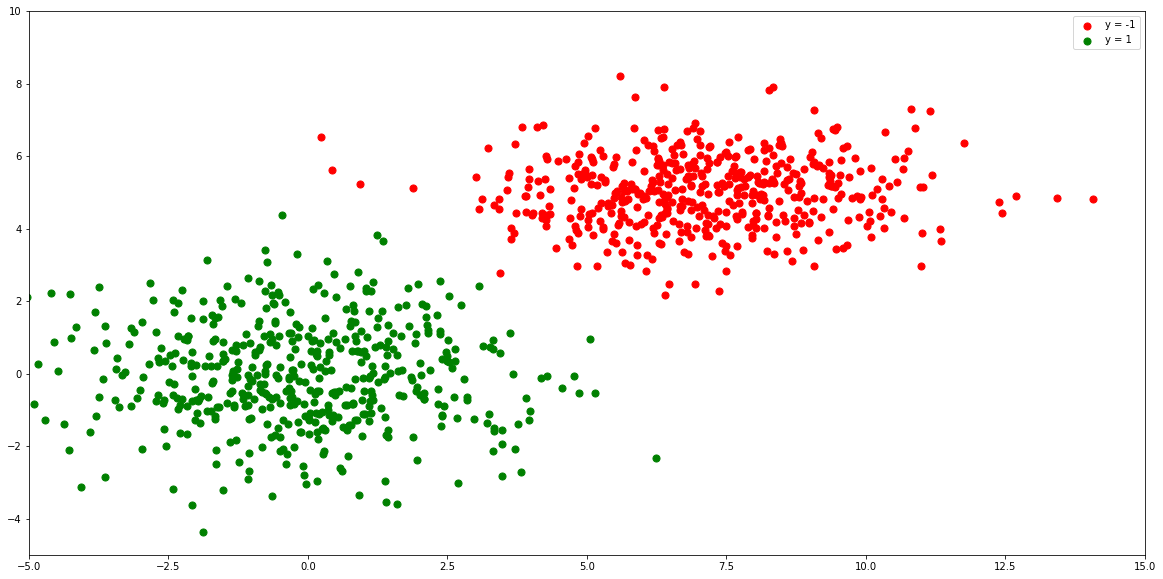

In [102]:
class_size=500

plt.figure(figsize=(20,10))
mean0 = [7, 5]
cov0 = [[4, 0], [0, 1]]  # diagonal covariance
mean1 = [0, 0]
cov1 = [[4, 0], [0, 2]]
data0 = np.random.multivariate_normal(mean0, cov0, class_size)
data1 = np.random.multivariate_normal(mean1, cov1, class_size)
data = np.vstack((data0, data1))
y = np.hstack((-np.ones(class_size), np.ones(class_size)))

plt.scatter(data0[:, 0], data0[:, 1], c='red', s=50)
plt.scatter(data1[:, 0], data1[:, 1], c='green', s=50)
plt.legend(['y = -1', 'y = 1'])
axes = plt.gca()
axes.set_xlim([-5,15])
axes.set_ylim([-5,10])
plt.show()

In [103]:
from sklearn.svm import SVC

SVM_classifier = SVC(C=0.01, kernel='linear') # changing C here
SVM_classifier.fit(data, y)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

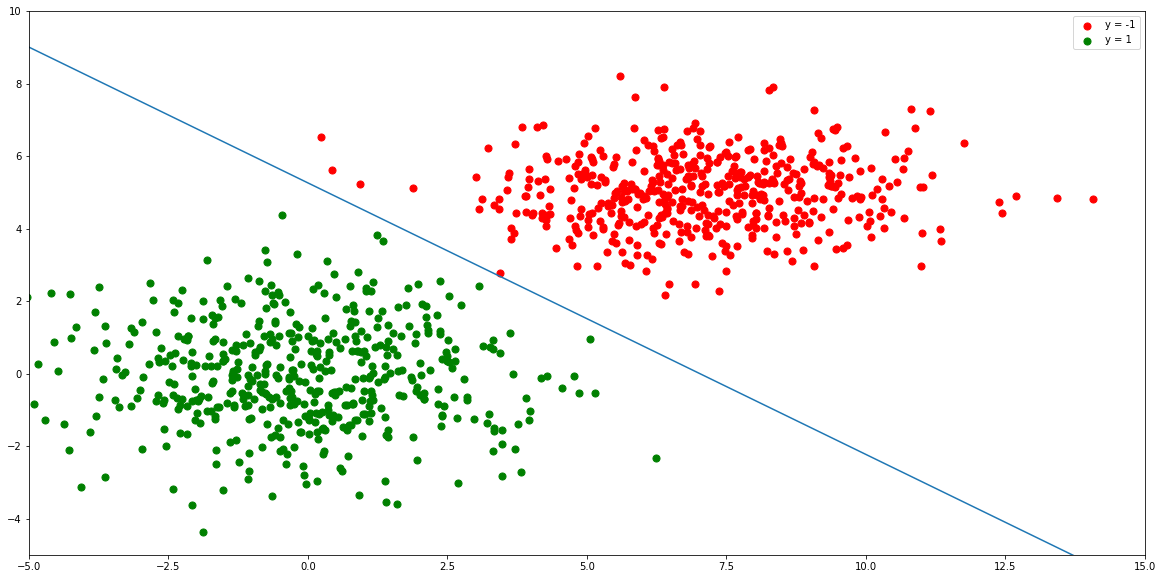

In [104]:
w_1 = SVM_classifier.coef_[0][0]
w_2 = SVM_classifier.coef_[0][1]
w_0 = SVM_classifier.intercept_[0]


plt.figure(figsize=(20,10))
plt.scatter(data0[:, 0], data0[:, 1], c='red', s=50)
plt.scatter(data1[:, 0], data1[:, 1], c='green', s=50)
plt.legend(['y = -1', 'y = 1'])
x_arr = np.linspace(-10, 15, 3000)
plt.plot(x_arr, -(w_0 + w_1 * x_arr) / w_2)
axes = plt.gca()
axes.set_xlim([-5,15])
axes.set_ylim([-5,10])
plt.show()

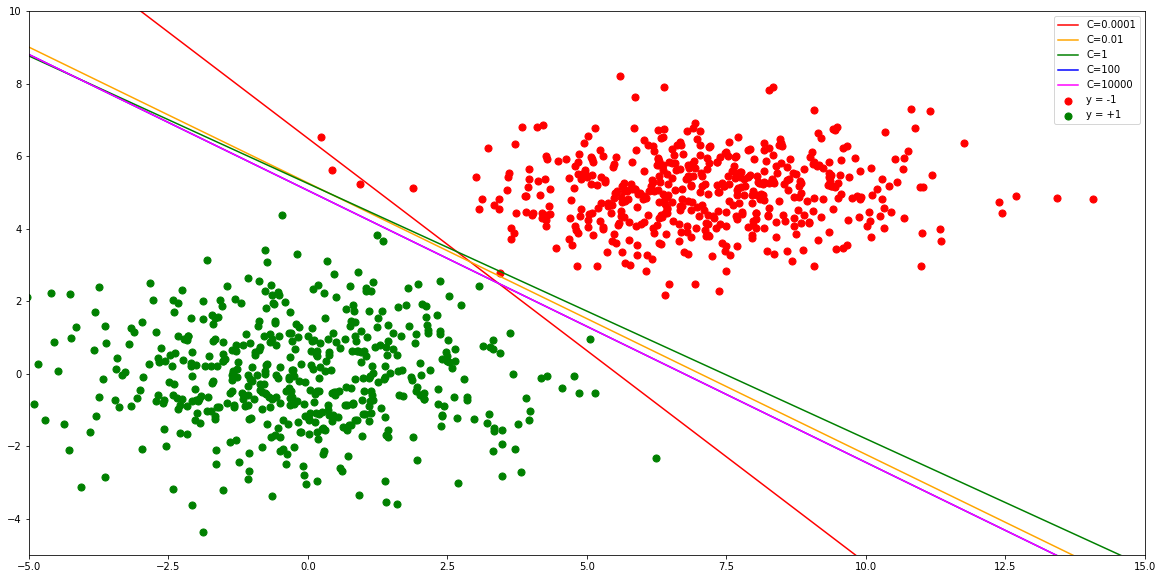

In [107]:
plt.figure(figsize=(20,10))
plt.scatter(data0[:, 0], data0[:, 1], c='red', s=50, label='y = -1')
plt.scatter(data1[:, 0], data1[:, 1], c='green', s=50, label='y = +1')
#plt.legend(['y = -1', 'y = 1'])
x_arr = np.linspace(-10, 15, 3000)
colors = ['red', 'orange', 'green', 'blue', 'magenta']

for i, C in enumerate([0.0001, 0.01,  1, 100, 10000]):
    SVM_classifier = SVC(C=C, kernel='linear')
    SVM_classifier.fit(data, y)
    w_1 = SVM_classifier.coef_[0][0]
    w_2 = SVM_classifier.coef_[0][1]
    w_0 = SVM_classifier.intercept_[0]
    plt.plot(x_arr, -(w_0 + w_1 * x_arr) / w_2, color=colors[i], label='C='+str(C))

axes = plt.gca()
axes.set_xlim([-5,15])
axes.set_ylim([-5,10])
plt.legend(loc=0)
plt.show()

Гиперпараметр $C$ отвечает за то, что является более приоритетным для классификатора, — "подгонка" под обучающую выборку или максимизация ширины разделяющей полосы.
 - При больших значениях $C$ классификатор сильно настраивается на обучение, тем самым сужая разделяющую полосу.
 - При маленьких значениях $C$ классификатор расширяет разделяющую полосу, при этом допуская ошибки на некоторых объектах обучающей выборки.